## **Set up**

In [19]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
import tracemalloc
import seaborn as sns
import random
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score , recall_score, f1_score

In [4]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


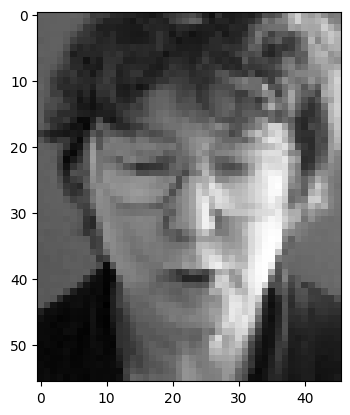

In [5]:
# show one example image
plt.imshow(np.reshape(x_train[:,0],(46,56)).T, cmap = 'gist_gray')

## **Additional Functions**

In [6]:
def draw_confusion_matrix(y_test, y_pred):
    # confusion matrix with 5 base eigenvectors
    cm = confusion_matrix(y_test.reshape(-1), y_pred)

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(1, 53), yticklabels=range(1, 53))
    plt.title(f'Confusion Matrix of RF')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [7]:
def print_results(accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth):
    print(f"Training Memory Usage (Peak): {train_peak_memory / 10**6:.3f} MB")
    print(f"Training Execution Time: {train_time:.8f} seconds")
    print('\n')

    print(f"Test Memory Usage (Peak): {test_peak_memory / 10**6:.3f} MB")
    print(f"Test Execution Time: {test_time:.6f} seconds")
    print('\n')

    print(f"Maximum depth of trees in the forest: {max_tree_depth}")

    print(f"Accuracy: {accuracy * 100:.2f}%")

In [70]:
def get_suc_fail_cases(y_test, y_pred):
    success_cases = []
    failure_cases = []
    for i in range(len(y_pred)):
        if y_test.T[i] == y_pred[i]:
            success_cases.append(y_test.T[i][0])
        else:
            failure_cases.append(y_test.T[i][0])
            
    return success_cases, failure_cases

In [9]:
def RF_classification(x_train, y_train, x_test, y_test, n_estimators=100, max_depth=1000, bootstrap=True, random_state=0, max_samples=0.8, max_features="sqrt", criterion='entropy', time_memory_check=False):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)

    # Train ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()
    
    rf_clf.fit(x_train.T, y_train.ravel())
    
    train_time = time.perf_counter() - start_time
    current, train_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Test ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()

    y_pred = rf_clf.predict(x_test.T)

    test_time = time.perf_counter()- start_time
    current, test_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    accuracy = accuracy_score(y_test.T, y_pred)

    # Full classification report
    # print(classification_report(y_test.T, y_pred, zero_division=0))

    # Retrieve the maximum depth of each tree in the forest
    tree_depths = [estimator.tree_.max_depth for estimator in rf_clf.estimators_]
    max_tree_depth = max(tree_depths)

    return accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth

In [10]:
def create_two_pixel_features(x_train, x_test, n_pairs=None, random_seed=None):
    x_combined = np.concatenate([x_train, x_test], axis=1)

    n_features, n_samples = x_combined.shape

    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Generate all unique pairs of features where i != j
    feature_pairs = [(i, j) for i in range(n_features) for j in range(i + 1, n_features)]

    # If n_pairs is specified, randomly select a subset of feature pairs
    if n_pairs is not None and n_pairs < len(feature_pairs):
        feature_pairs = random.sample(feature_pairs, n_pairs)
    
    # Initialize a new features matrix for pairwise differences
    new_features = np.zeros((len(feature_pairs), n_samples))

    # Fill in the new features with pairwise differences
    for idx, (i, j) in enumerate(feature_pairs):
        new_features[idx, :] = x_combined[i, :] - x_combined[j, :]

    x_train_2pix = new_features[:, :x_train.shape[1]]
    x_test_2pix = new_features[:, x_train.shape[1]:]

    return x_train_2pix, x_test_2pix

In [147]:
def avg_results(num_iter, x_train, y_train, x_test, y_test, n_estimators=5, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy'):
    results_array = np.zeros((6,))
    
    for i in range(num_iter):
        accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, y_test, n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)
        results_array += np.array([accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth])

    results_array /= num_iter
    return results_array

In [12]:
def show_suc_fail_histogram(suc_label, fail_case_true_label):
    # Show success cases ------------------------------------------------
    bins = 52

    # Plotting the histograms
    plt.figure(figsize=(15, 6))
    plt.hist(suc_label, bins=bins, label='Success', color='b')
    plt.xlabel('True Label')
    plt.ylabel('Count Cases')
    plt.title('Histogram of Success Cases')
    plt.legend()
    plt.xlim(left=1, right=52)

    plt.xticks([i for i in range(1, 53)])
    plt.yticks([1, 2])

    plt.show()

    # Show failure cases ------------------------------------------------
    bins = 52

    # Plotting the histograms
    plt.figure(figsize=(15, 6))
    plt.hist(fail_case_true_label, bins=bins, label='Failure', color='r')
    plt.xlabel('True Label')
    plt.ylabel('Count Cases')
    plt.title('Histogram of Failure Cases')
    plt.legend()
    plt.xlim(left=1, right=52)

    plt.xticks([i for i in range(1, 53)])
    plt.yticks([1, 2])

    plt.show()

## **Q5. RF classifier**

### Weak learner: Axis-aligend test

In [145]:
# default_settings
# n_estimators=50
# max_depth=10
# bootstrap=True
# random_state=0
# max_samples=0.7
# max_features="sqrt"
# criterion='entropy'

# Get results
accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, y_test, n_estimators=50, max_depth=10, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True)

# Print results
print_results(accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth)

# Draw confusion matrix
# draw_confusion_matrix(y_test, y_pred)

# # Get success and failure examples
# success_cases, failute_cases = get_suc_fail_cases(y_test, y_pred)

# # Show success case and failure cases histogram
# show_suc_fail_histogram(success_cases, failute_cases)

Training Memory Usage (Peak): 4.470 MB
Training Execution Time: 1.17184990 seconds


Test Memory Usage (Peak): 1.172 MB
Test Execution Time: 0.003774 seconds


Maximum depth of trees in the forest: 10
Accuracy: 75.00%


### Weak learner: Two-Pixel Test

In [146]:
x_train_2pix, x_test_2pix = create_two_pixel_features(x_train, x_test, n_pairs=2576, random_seed=0)

# Get results
accuracy, y_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train_2pix, y_train, x_test_2pix, y_test, n_estimators=150, max_depth=10, bootstrap=True, random_state=1, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True)

# Print results
print_results(accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth)

# Draw confusion matrix
# draw_confusion_matrix(y_test, y_pred)

# # Get success and failure examples
# suc_idx, suc_label, fail_idx, fail_case_prediction_label, fail_case_true_label = get_suc_fail_cases(y_test, y_pred)

# # Show success case and failure cases histogram
# show_suc_fail_histogram(suc_label, fail_case_true_label)

Training Memory Usage (Peak): 4.627 MB
Training Execution Time: 3.71368850 seconds


Test Memory Usage (Peak): 1.173 MB
Test Execution Time: 0.009549 seconds


Maximum depth of trees in the forest: 10
Accuracy: 87.50%


### Average result

In [148]:
# average result of two-pixel test
num_iter = 10

results_array = avg_results(num_iter, x_train, y_train, x_test, y_test, n_estimators=5, max_depth=15, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy')

print(f'average results with {num_iter} iterations')
print_results(results_array[0], results_array[1], results_array[2], results_array[3], results_array[4], results_array[5])

average results with 10 iterations
Training Memory Usage (Peak): 4.390 MB
Training Execution Time: 0.12096359 seconds


Test Memory Usage (Peak): 1.171 MB
Test Execution Time: 0.001165 seconds


Maximum depth of trees in the forest: 9.0
Accuracy: 33.65%


axis-aligned

In [157]:
interval = 50
num_iter = 15

num_estimators_lst = []

axis_acc_result = []
axis_train_runtime_result = []
axis_test_runtime_result = []
axis_train_peak_mem_result = []
axis_test_peak_mem_result = []

for i in range(1, 5):
    n_estimators = interval*i
    num_estimators_lst.append(n_estimators)
    
    # Get each PCA result
    results_array = avg_results(num_iter, x_train, y_train, x_test, y_test, n_estimators=n_estimators, max_depth=10, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy')

    # accuracy arrays
    axis_acc_result.append(results_array[0])
    # runtime arrays -> seconds
    # axis_train_runtime_result.append(results_array[1])
    # axis_test_runtime_result.append(results_array[2])
    # # peak memory arrays -> Mega Bite (MB)

    # axis_train_peak_mem_result.append(results_array[3] / 1024**2)
    # axis_test_peak_mem_result.append(results_array[4] / 1024**2)



two-pixel

In [158]:
n_pairs=2576
x_train_2pix, x_test_2pix = create_two_pixel_features(x_train, x_test, n_pairs=n_pairs, random_seed=1)

num_estimators_lst = []

tp_acc_result = []
tp_train_runtime_result = []
tp_test_runtime_result = []
tp_train_peak_mem_result = []
tp_test_peak_mem_result = []

for i in range(1, 5):
    n_estimators = interval*i
    num_estimators_lst.append(n_estimators)
    
    # Get each PCA result
    results_array = avg_results(num_iter, x_train_2pix, y_train, x_test_2pix, y_test, n_estimators=n_estimators, max_depth=10, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy')

    # accuracy arrays
    tp_acc_result.append(results_array[0])
    # runtime arrays -> seconds
    # tp_train_runtime_result.append(results_array[1])
    # tp_test_runtime_result.append(results_array[2])
    # # peak memory arrays -> Mega Bite (MB)

    # tp_train_peak_mem_result.append(results_array[3] / 1024**2)
    # tp_test_peak_mem_result.append(results_array[4] / 1024**2)

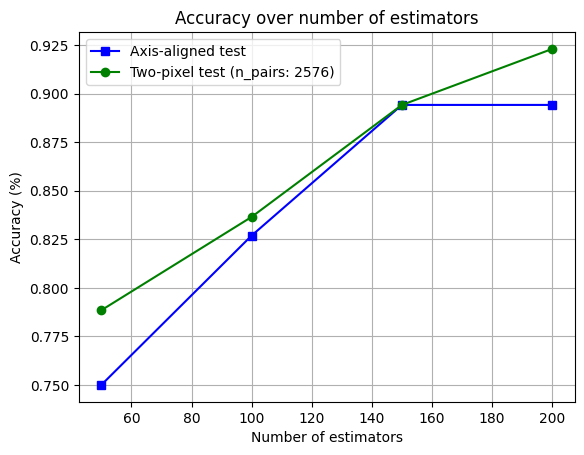

In [159]:
# fig, axes = plt.subplots(1, 4, figsize=(20, 8))

# Plot accuracy on the first subplot
plt.plot(num_estimators_lst, axis_acc_result, label='Axis-aligned test', marker='s', linestyle='-', color='b')
plt.plot(num_estimators_lst, tp_acc_result, label=f'Two-pixel test (n_pairs: {n_pairs})', marker='o', linestyle='-', color='g')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over number of estimators')
plt.legend()
plt.grid(True)

### Hyperparameter Tuning

In [84]:
# Hyperparameter tuning
def RF_random_search(x_train, y_train, x_test, y_test, n_iter, cv, random_state=None):
    # Search settings
    rf_clf = RandomForestClassifier(n_estimators=50, bootstrap=True, random_state=random_state)

    param_distributions = dict()
    param_distributions['n_estimators'] = [10*i for i in range(20, 30)]
    # param_distributions['max_depth'] = [i for i in range(5,21)]
    param_distributions['max_samples'] = [0.1 * i for i in range(1,11)]
    param_distributions['max_features'] = ['sqrt', 'log2']
    param_distributions['criterion'] = ["gini", "entropy"]
    
    random_search = RandomizedSearchCV(rf_clf, param_distributions, n_iter=n_iter, scoring='accuracy', cv=cv, n_jobs=-1)
    random_result = random_search.fit(x_train.T, y_train.ravel())

    print(f'Best Parameters: {random_search.best_params_}')
    print(f'Best Accuracy: {random_result.best_score_}')

    best_rf = random_search.best_estimator_

    y_pred = best_rf.predict(x_test.T)
    accuracy = accuracy_score(y_test.T, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return random_search.best_estimator_

best_rf = RF_random_search(x_train, y_train, x_test, y_test, n_iter=30, cv=5, random_state=0)

Best Parameters: {'n_estimators': 270, 'max_samples': 0.9, 'max_features': 'log2', 'criterion': 'entropy'}
Best Accuracy: 0.620453241537579
Accuracy: 85.58%


## Results Comparison

In [57]:
def print_comp_results(y_pred, y_test, train_run_time, test_run_time):
    accuracy = accuracy_score(y_test.T, y_pred)
    precision = precision_score(y_test.T, y_pred,average= "macro", zero_division=0)
    recall = recall_score(y_test.T, y_pred, average= "macro", zero_division=0)
    f1 = f1_score(y_test.T, y_pred, average= "macro", zero_division=0)
    print(f'Accuracy of PCA: {accuracy:.3f}')
    print(f'Precision of PCA: {precision:.3f}')
    print(f'Recall of PCA: {recall:.3f}')
    print(f'f1 socre of PCA: {f1:.3f}')
    print(f'Train Runtime: {train_run_time:.3f} seconds')
    print(f'Test Runtime: {test_run_time:.3f} seconds')
    print('\n')

In [111]:
def suc_fail_cnt(y_test, y_pred):
    success_cnt = [0] * 52
    failure_cnt = [0] * 52

    for i in range(len(y_pred)):
        if y_test.T[i] == y_pred[i]:
            success_cnt[y_test.T[i][0]-1] += 1
        else:
            failure_cnt[y_test.T[i][0]-1] = 1

    return success_cnt, failure_cnt

### PCA & NN

In [58]:
def pca_nn(n_components, x_train, y_train, x_test, y_test):
    start_time = time.perf_counter()

    pca = PCA(n_components=n_components)
    pca.fit(x_train.T)

    # Applying NN algorithm
    x_train_proj = pca.transform(x_train.T).T
    x_test_proj = pca.transform(x_test.T).T

    nn = KNeighborsClassifier(n_neighbors=1)
    nn.fit(x_train_proj.T, y_train.reshape(-1))
    train_run_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    # Get accuracy
    y_pred = nn.predict(x_test_proj.T)

    test_run_time = time.perf_counter() - start_time

    return y_pred, train_run_time, test_run_time

In [79]:
num_iter = 15
num_bases = 415

avg_train_run_time = 0
avg_test_run_time = 0

for i in range(num_iter):
    y_pred, train_run_time, test_run_time = pca_nn(num_bases, x_train, y_train, x_test, y_test)
    avg_train_run_time += train_run_time
    avg_test_run_time += test_run_time

avg_train_run_time /= num_iter
avg_test_run_time /= num_iter

print_comp_results(y_pred, y_test, avg_train_run_time, avg_test_run_time)

Accuracy of PCA: 0.673
Precision of PCA: 0.627
Recall of PCA: 0.673
f1 socre of PCA: 0.619
Train Runtime: 0.210 seconds
Test Runtime: 0.006 seconds




In [ ]:
# For fianl success and failure analysis
pca_success_cases, pca_failure_cases = get_suc_fail_cases(y_test, y_pred)

### PCA-LDA & NN

### RF

In [139]:
# default_settings
# n_estimators=50
# max_depth=10
# bootstrap=True
# random_state=0
# max_samples=0.7
# max_features="sqrt"
# criterion='entropy'

# Get results
accuracy, y_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test, y_test, n_estimators=15, max_depth=10, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True)

# Print results
print_results(accuracy, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth)

Training Memory Usage (Peak): 4.469 MB
Training Execution Time: 0.35295930 seconds


Test Memory Usage (Peak): 1.172 MB
Test Execution Time: 0.001674 seconds


Maximum depth of trees in the forest: 10
Accuracy: 67.31%


In [ ]:
num_iter = 15

avg_train_run_time = 0
avg_test_run_time = 0

for i in range(num_iter):
    accuracy, y_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test, y_test, n_estimators=50, max_depth=10, bootstrap=True, random_state=0, max_samples=0.7, max_features="sqrt", criterion='entropy', time_memory_check=True)
    avg_train_run_time += train_time
    avg_test_run_time += test_time

avg_train_run_time /= num_iter
avg_test_run_time /= num_iter

print_comp_results(y_pred, y_test, avg_train_run_time, avg_test_run_time)

Accuracy of PCA: 0.750
Precision of PCA: 0.729
Recall of PCA: 0.750
f1 socre of PCA: 0.714
Train Runtime: 1.163 seconds
Test Runtime: 0.004 seconds




In [140]:
# For fianl success and failure analysis
rf_success_cases, rf_failure_cases = suc_fail_cnt(y_test, y_pred)

### Overall results

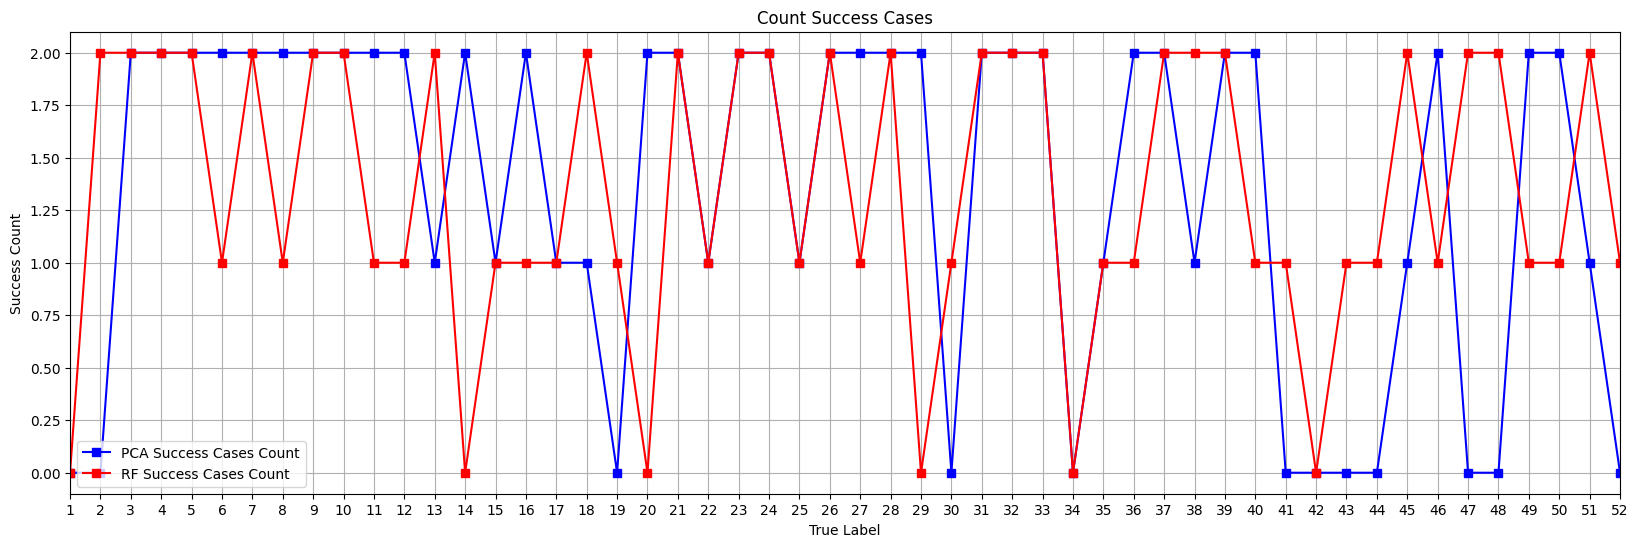

In [141]:
x_idx = [i for i in range(1,53)]

# Plot accuracy on the first subplot
plt.figure(figsize=(20, 6))
plt.plot(x_idx, pca_success_cases, label='PCA Success Cases Count', marker='s', color='b')
plt.plot(x_idx, rf_success_cases, label='RF Success Cases Count', marker='s', color='r')
plt.xticks(x_idx)
plt.xlim(left=1, right=52)
plt.title('Count Success Cases')
plt.xlabel('True Label')
plt.ylabel('Success Count')
# plt.title('Accuracy over number of estimators')
plt.legend()
plt.grid(True)

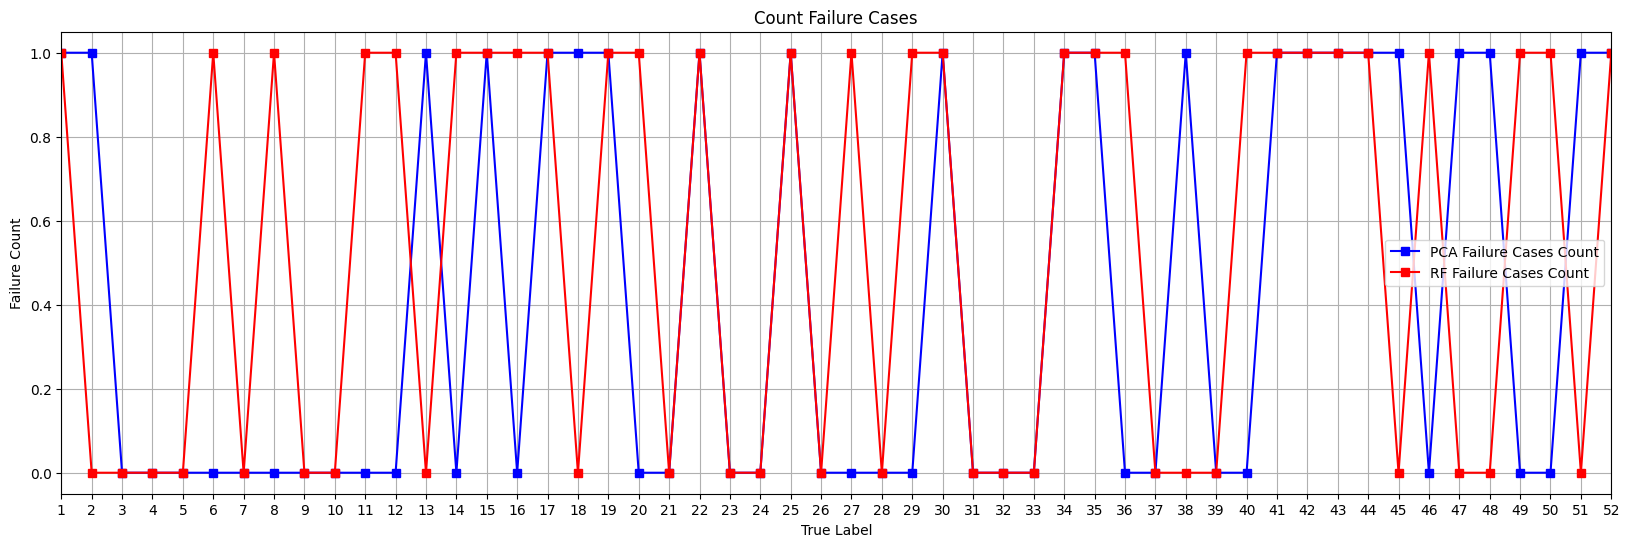

In [142]:
# Plot accuracy on the first subplot
plt.figure(figsize=(20, 6))
plt.plot(x_idx, pca_failure_cases, label='PCA Failure Cases Count', marker='s', color='b')
plt.plot(x_idx, rf_failure_cases, label='RF Failure Cases Count', marker='s', color='r')
plt.xticks(x_idx)
plt.xlim(left=1, right=52)
plt.title('Count Failure Cases')
plt.xlabel('True Label')
plt.ylabel('Failure Count')
# plt.title('Accuracy over number of estimators')
plt.legend()
plt.grid(True)

In [143]:
correlation = np.corrcoef(pca_failure_cases, rf_failure_cases)[0, 1]
print(f"Correlation between failure cases: {correlation}")

Correlation between failure cases: 0.16817499303650424
